In [1]:
from dataclasses import dataclass

In [2]:
@dataclass
class Gate:
    obstacle_gates: list
    boundary_gates: list
    start_end_gates: list
        

In [3]:
from shapely.geometry import Polygon, LineString
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [4]:
def slope(line: LineString) -> float:
    """
    Calculate the slope of a LineString.

    This function takes a LineString object as input and calculates the slope
    of the line defined by its coordinates. The slope is calculated as the
    change in y-coordinates divided by the change in x-coordinates between the
    first and second points of the line.

    Args:
        line (LineString): A LineString object representing the line for which
            to calculate the slope.

    Returns:
        float: The calculated slope of the line, rounded to three decimal places.

    Raises:
        ZeroDivisionError: If the change in x-coordinates (denominator) is zero,
            indicating a vertical line with undefined slope.

    Example:
        >>> line = LineString([(0, 0), (2, 4)])
        >>> slope_value = slope(line)
        >>> print(slope_value)
        2.0
    """
    # Extract coordinates of the first and second points
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]

    # Calculate the change in x-coordinates
    dx = x2 - x1

    # Check for vertical line (undefined slope)
    if dx == 0:
        raise ZeroDivisionError("The line is vertical, and its slope is undefined.")

    # Calculate the slope
    slope = (y2 - y1) / dx
    
    # Round the slope to three decimal places
    slope = round(slope, 3)
    
    return slope


In [5]:
import numpy as np
from shapely.geometry import LineString
from collections import defaultdict

def line_eqs_delaunay(points: np.array, simplices) -> list:
    """
    Generate a list of unique LineString equations for the given Delaunay triangulation.

    Given an array of points and their Delaunay triangulation simplices, this function
    generates a list of LineString equations representing the unique lines formed by
    the vertices of the simplices.

    Args:
        points (np.array): An array of 2D points.
        simplices: The simplices of the Delaunay triangulation.

    Returns:
        list: A list of LineString objects representing unique lines formed by the
        vertices of the Delaunay triangulation.

    Example:
        >>> points = np.array([[0, 0], [1, 2], [3, 1]])
        >>> simplices = [(0, 1, 2)]
        >>> lines = line_eqs_delaunay(points, simplices)
        >>> print(lines)
        [LINESTRING (0 0, 1 2), LINESTRING (1 2, 3 1), LINESTRING (3 1, 0 0)]
    """
    lines = []

    # Generate LineString objects for each simplex
    for simplex in simplices:
        vertices = points[simplex]
        for i in range(3):
            for j in range(i + 1, 3):
                lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))

    # Create a dictionary to group lines by slope
    line_dict = defaultdict(list)

    # Calculate slope for each line and group them
    for line in lines:
        slp = slope(line)
        line_dict[slp].append(line)

    filtered_lines = []

    # Choose one representative line for each slope
    for slp, line_list in line_dict.items():
        filtered_lines.append(line_list[0])

    return filtered_lines

In [6]:
from shapely.geometry import LineString

def line_eqs_inside_poly(lines, obstacle_list):
    """
    Finds intersections between a list of lines and a list of obstacles, 
    and returns the coordinates of the points where the lines intersect 
    with the obstacles.
    
    Args:
        lines (list): A list of lines represented as pairs of coordinates.
        obstacle_list (list): A list of obstacle polygons represented as 
                             Shapely geometry objects.
                             
    Returns:
        list: A list of lists containing coordinates of points where lines 
              intersect with obstacles.
    """
    
    line_eqs_in_poly = []  # Store intersections between lines and obstacles.

    for line in lines:
        for obstacle in obstacle_list:
            if obstacle.intersects(LineString(line)):
                # Append the intersection point to the list of intersections.
                line_eqs_in_poly.append(obstacle.intersection(LineString(line)))
                
    # Convert intersection points to lists of coordinates.
    line_inside_poly = [[list(coord) for coord in line.coords] for line in line_eqs_in_poly]

    return line_inside_poly


In [7]:
from shapely.geometry import LineString

def LongSeg_SmallSeg(lines, line_inside_poly):
    """
    Finds and associates small line segments with corresponding long line segments
    based on matching slopes and returns a dictionary containing the associations.

    Args:
        lines (list): A list of long line segments represented as pairs of coordinates.
        line_inside_poly (list): A list of lists containing coordinates of points where
                                 lines intersect with obstacles.

    Returns:
        dict: A dictionary where keys are long line segments (LineString objects) and 
              values are lists of coordinates representing associated small line segment points.
    """

    diction_lines = {LineString(long_line_segs): [] for long_line_segs in lines}

    for long_line_segs in lines:
        for small_line_segs in line_inside_poly:
            if slope(LineString(long_line_segs)) == slope(LineString(small_line_segs)):
                for i in range(2):
                    key = LineString(long_line_segs)
                    if key in diction_lines:
                        if small_line_segs[i] not in diction_lines[key]:
                            diction_lines[key].append(small_line_segs[i])

    #filtered_diction_lines = {key: value for key, value in diction_lines.items() if len(value) == 2}

    return diction_lines


In [11]:
from shapely.geometry import LineString

def gates_for_GStar(M: ObstacleMap, diction_lines):
    """
    Generates gate LineString objects for a graph G* based on the given dictionary
    of associated small line segment points with long line segments.

    Args:
        diction_lines (dict): A dictionary where keys are long line segments (LineString objects) 
                             and values are lists of coordinates representing associated small line segment points.

    Returns:
        list: A list of gate LineString objects for the graph G*.
    """
    
    # Iterate through each key-value pair in the dictionary.
    for key, value in diction_lines.items():
        # Iterate through the two endpoints of the long line segment.
        for i in range(2):
            # Check if the endpoint is in the list of associated small line segment points.
            if list(key.coords[i]) in value:
                # Remove the endpoint from the list to avoid duplicate gates.
                diction_lines[key].remove(list(key.coords[i]))

    gates1 = []  # Store the LineString gate objects.

    # Create LineString objects for the remaining points and add them to the gates list.
    for values in diction_lines.values():
        if len(values) != 0:
            gates1.append(LineString(values))
    
    # Filter out gates that have more than two coordinates.
    obstacle_gates = [gate for gate in gates1 if len(gate.coords) == 2]
    
    boundary_gates = []
    
    for point in M.convex_hull_vertices:
#         print(point)
#         print(type(point))
        if point[1] >= (0.5 * M.ymax):
            gate = LineString([point, (point[0], M.ymax)])
            
            
        else:
            gate = LineString([point, (point[0], M.ymin)])
        
       
        boundary_gates.append(gate)
        
    
    filtered_boundary_gates = []

    for gate in boundary_gates:
        count = 0
        for obstacle in M.ObstacleList:
            if gate.intersects(obstacle):
                count += 1

        if count == 1:
            filtered_boundary_gates.append(gate)
    
    updates_boundary_gates = []
    
    for gate in filtered_boundary_gates:
        for obs in M.ObstacleList:
            if gate.intersects(obs):
                new_gate = gate - obs
                updates_boundary_gates.append(new_gate)
                
            else:
                continue
    
    start_end_gates = []
    
    start_gate = LineString([(M.StartCoords.coords[0][0], M.StartCoords.coords[0][1] - 0.1), (M.StartCoords.coords[0][0], M.StartCoords.coords[0][1] + 0.1)])
    end_gate = LineString([(M.EndCoords.coords[0][0], M.EndCoords.coords[0][1] - 0.1), (M.EndCoords.coords[0][0], M.EndCoords.coords[0][1] + 0.1)])
            
    start_end_gates.append(start_gate)
    start_end_gates.append(end_gate)
        
    
    
    
    
    gates = Gate(obstacle_gates = obstacle_gates, boundary_gates = updates_boundary_gates, start_end_gates = start_end_gates)
    
    return gates


TypeError: 'Gate' object is not iterable

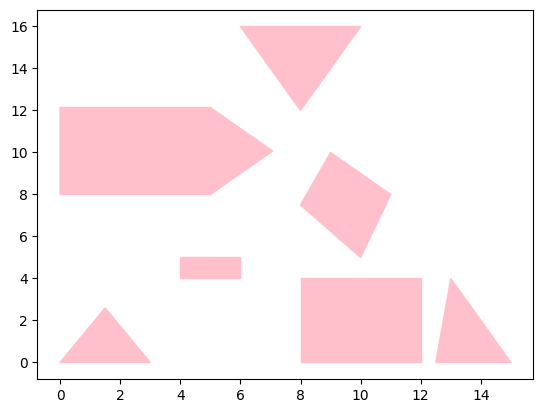

In [18]:
# Create a polygon with 3 sides (equilateral triangle)
triangle = Polygon([(0, 0), (3, 0), (1.5, 2.598)])

# Create a polygon with 4 sides (square)
square = Polygon([(8, 0), (12, 0), (12, 4), (8, 4)])

# Create a polygon with 5 sides (regular pentagon)
pentagon = Polygon([(0, 8), (5, 8), (7.071, 10.071), (5, 12.142), (0, 12.142)])

triangle_new = Polygon([(12.5,0),(15, 0), (13, 4)])

triangle_onemore = Polygon([(8,12),(6, 16), (10, 16)])

rectangle = Polygon([(4, 4), (6, 4), (6, 5), (4, 5)])

pentagon_new = Polygon([(10, 5), (8, 7.5), (9, 10), (10, 9), (11, 8)])

obstacle_list = [triangle, square, pentagon, triangle_new, triangle_onemore, rectangle, pentagon_new]

centroid_list = []

for obstacle in obstacle_list:
    centroid_list.append(list(obstacle.centroid.coords))


points = np.array(centroid_list)
points = points.reshape(-1,2)

tri = Delaunay(points)
simplices = tri.simplices

lines = line_eqs_delaunay(points, simplices)

line_inside_poly = line_eqs_inside_poly(lines, obstacle_list)


diction_lines = LongSeg_SmallSeg(lines, line_inside_poly)

#filtered_lines = filtered_diction_lines(diction_lines)

gates = gates_for_GStar(M, diction_lines)



# Create a figure and axis
fig, ax = plt.subplots()



for obstacle in obstacle_list:
    x,y = obstacle.exterior.xy
    ax.fill(x, y, color = 'pink')


# plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k--')
# plt.plot(points[:,0], points[:,1], 'o')

for gate in gates:
    x, y = gate.xy
    plt.plot(x, y, 'c-', linewidth=2)

# Set axis limits
ax.set_xlim(-1, 18)
ax.set_ylim(-1, 18)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Non-vertical gates representation')

# Show the plot
plt.show()




In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from scipy.spatial import ConvexHull

class ObstacleMap:
    
    def __init__(self, StartConf: tuple, EndConf: tuple, MapBounds: tuple, ObstaclesNum: int, Shape: int):
        """
        Initialize an obstacle map with given parameters.

        Args:
            StartConf (tuple): Start configuration coordinates.
            EndConf (tuple): End configuration coordinates.
            MapBounds (tuple): Map boundary dimensions (x_max, y_max).
            ObstaclesNum (int): Number of obstacles to generate.
            Shape (int): Number of sides in polygon obstacles (minimum 3).

        Raises:
            Exception: If Shape is less than 3.
        """
        
        self.xmin, self.xmax = 0, MapBounds[0]
        self.ymin, self.ymax = 0, MapBounds[1]
        
        self.StartCoords = Point(StartConf[0], StartConf[1])
        self.EndCoords = Point(EndConf[0], EndConf[1])
        
        if Shape < 3:
            raise Exception("Min Num of sides in a Polygon is 3")
        else:
            self.ObstacleList, self.CentroidList = self.generate_polygon_obstacles(MapBounds, ObstaclesNum, Shape)
            self.convex_hull_vertices = self.__get_largest_polygon_coordinates()
    
    def __get_angles(self, num_of_sides: int) -> list:
        """
        Generate a list of angles for the vertices of a polygon.

        Args:
            num_of_sides (int): Number of sides in the polygon.

        Returns:
            list: List of angles in radians.
        """
        random_numbers = [random.uniform(0, 1) for _ in range(num_of_sides)]
        normalized_numbers = [num / sum(random_numbers) for num in random_numbers]
        angles = np.cumsum([2*np.pi * x for x in normalized_numbers])
        angles_list = list(angles)
        return angles_list
    
    def __get_vertices(self, center: np.array, radius: float, angles_list: list):
        """
        Calculate vertices of a polygon based on center, radius, and angles.

        Args:
            center (np.array): Center coordinates of the polygon.
            radius (float): Radius of the polygon.
            angles_list (list): List of angles in radians.

        Returns:
            np.array: Array of vertices for the polygon.
        """
        vertices = np.array([center + np.array([radius*np.cos(angle), radius*np.sin(angle)]) for angle in angles_list])
        return vertices
    
    def __get_largest_polygon_coordinates(self):
        
        points = np.array(self.CentroidList)
        points = points.reshape(-1,2)
        
        unique_coords = np.unique(points, axis=0)
        hull = ConvexHull(unique_coords)
        convex_hull_vertices = hull.points[hull.vertices]
        
        return convex_hull_vertices

    
    def generate_polygon_obstacles(self, MapBounds: tuple, ObstaclesNum: int, Shape: int):
        """
        Generate a list of polygon obstacles.

        Args:
            MapBounds (tuple): Map boundary dimensions (x_max, y_max).
            ObstaclesNum (int): Number of obstacles to generate.
            Shape (int): Number of sides in polygon obstacles.

        Returns:
            list: List of Shapely Polygon obstacles.
        """
        xmin, xmax = 0, MapBounds[0]
        ymin, ymax = 0, MapBounds[1]
        
        Boundary1 = LineString([(xmin, ymin), (xmax, ymin)])
        Boundary2 = LineString([(xmax, ymin), (xmax, ymax)])
        Boundary3 = LineString([(xmax, ymax), (xmin, ymax)])
        Boundary4 = LineString([(xmin, ymin), (xmin, ymax)])
        
        map_boundaries = [Boundary1, Boundary2, Boundary3, Boundary4]
        
        min_distance = 0.5
        ObstacleList = []
        CentroidList = []
        count = 0
        while count < ObstaclesNum:
            radius = random.uniform(0.07, 0.08) * xmax
            center = np.array([np.random.rand() * xmax, np.random.rand() * ymax])
            
            
            if Shape == 3:
                pshape = 3
            else:
                pshape = np.random.randint(low=3, high=Shape)
            
            angles_list = self.__get_angles(pshape)
            vertices = self.__get_vertices(center, radius, angles_list)
            polygon = Polygon(vertices)
            x, y = polygon.exterior.xy
            
            intersects_obstacle = False
            for existing_obstacle in ObstacleList:
                if polygon.intersects(existing_obstacle) or polygon.distance(existing_obstacle) < min_distance or \
                polygon.intersects(self.StartCoords) or polygon.intersects(self.EndCoords):
                    intersects_obstacle = True
                    break
                    
            intersects_boundaries = False
            for boundary in map_boundaries:
                if polygon.intersects(boundary):
                    intersects_boundaries = True
                    break
                    
                    
            centroid_outside = False
            x_centroid = polygon.centroid.coords[0][0]
            y_centroid = polygon.centroid.coords[0][1]
            
            if x_centroid > xmax and x_centroid < xmin and y_centroid > ymax and y_centroid < ymin:
                centroid_outside = True
                
                
            vertices_within_range = True
            for i in range(len(list(polygon.exterior.coords))):
                x_vertex = polygon.exterior.coords[i][0]
                y_vertex = polygon.exterior.coords[i][1]
                
                if (self.StartCoords.x + 1) <= x_vertex <= (self.EndCoords.x - 1) and (ymin + 1) <= y_vertex <= (ymax - 1):
                    continue
                    
                else:
                    vertices_within_range = False
                    
            
            
            
            
            if not intersects_obstacle and not intersects_boundaries and not centroid_outside and vertices_within_range:
                ObstacleList.append(polygon)
                
                CentroidList.append(list(polygon.centroid.coords))
                count += 1
                
                
        
                
                
                
        
        return ObstacleList, CentroidList
    
    def generate_plot(self):
        """
        Generate a plot to visualize the obstacle map.
        """
        plt.axis('equal')
        for obstacle in self.ObstacleList:
            x, y = obstacle.exterior.xy
            plt.fill(x, y, c="blue")
            
        plt.scatter(self.convex_hull_vertices[:,0], self.convex_hull_vertices[:,1])
        
        plt.plot([self.xmin, self.xmax, self.xmax, self.xmin, self.xmin], [self.ymin, self.ymin, self.ymax, self.ymax, self.ymin], color='black')
            
        plt.plot(self.StartCoords.x, self.StartCoords.y, "X", color ="black")
        plt.plot(self.EndCoords.x, self.EndCoords.y, "X", color = "black")
        
#         plt.figure(figsize=(140,14))
#         plt.figure().set_figwidth(15)
        plt.show()


In [20]:
StartConf = (0.5, 5, 5.78)
EndConf = (9.5, 5, 2.79)
MapBounds=(10.0, 10.0)
ObstaclesNum= 15
Shape=6

In [21]:
M = ObstacleMap(StartConf, EndConf, MapBounds, ObstaclesNum, Shape)

In [22]:
M.convex_hull_vertices

array([[7.53240037, 1.44383034],
       [7.88507702, 3.92058963],
       [7.54923003, 7.41086981],
       [5.41659524, 8.07345317],
       [2.41852431, 7.72436979],
       [2.24207321, 5.71465365],
       [2.20529232, 4.41366602],
       [2.21797105, 3.16512763],
       [2.93919295, 2.05178927]])

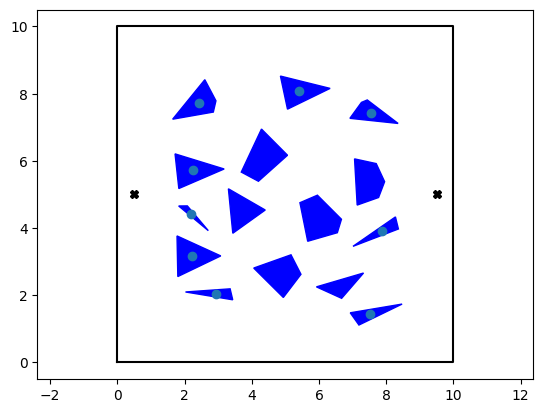

In [23]:
M.generate_plot()

In [24]:
M.CentroidList

[[(6.0022789194568595, 4.276836623512884)],
 [(2.418524308868696, 7.724369794903194)],
 [(2.205292317093742, 4.413666021431602)],
 [(6.642578547388863, 2.274133249580143)],
 [(2.939192948995665, 2.051789265749244)],
 [(4.8528961475200685, 2.6326204692661554)],
 [(5.416595244471528, 8.073453172157883)],
 [(7.453009068615086, 5.391656044356907)],
 [(7.549230028905151, 7.410869813838976)],
 [(4.338466225695975, 6.104164063978037)],
 [(3.7143800807116905, 4.51755370295099)],
 [(2.2420732083990615, 5.714653653675728)],
 [(7.532400372933727, 1.4438303410726963)],
 [(7.88507702048176, 3.9205896251776338)],
 [(2.217971052768492, 3.165127628276015)]]

In [25]:
list(M.ObstacleList[-5].exterior.coords)

[(3.3050553694360225, 5.168925288198136),
 (3.4364190978340603, 3.8462642399969833),
 (4.40166577486499, 4.537471580657851),
 (3.3050553694360225, 5.168925288198136)]

In [26]:
list(M.ObstacleList[0].exterior.coords)

[(5.954344628147593, 4.978723341662636),
 (5.434072656551364, 4.754975409893421),
 (5.665570442979828, 3.6075571011609453),
 (6.547418332721589, 3.8623469754194404),
 (6.669898008296034, 4.262807882275942),
 (5.954344628147593, 4.978723341662636)]

In [27]:
M.StartCoords.y

5.0

In [54]:
StartConf = (0.5, 5, 5.78)
EndConf = (9.5, 5, 2.79)
MapBounds=(10.0, 10.0)
ObstaclesNum= 15
Shape=6

In [55]:
M = ObstacleMap(StartConf, EndConf, MapBounds, ObstaclesNum, Shape)

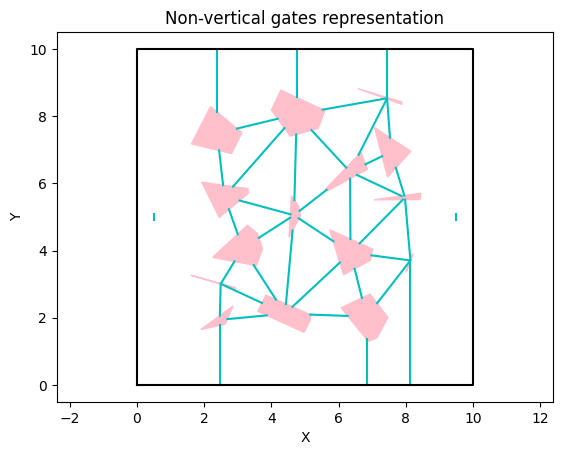

In [56]:
obstacle_list, centroid_list = M.ObstacleList, M.CentroidList

points = np.array(centroid_list)
points = points.reshape(-1,2)

tri = Delaunay(points)
simplices = tri.simplices

lines = line_eqs_delaunay(points, simplices)

line_inside_poly = line_eqs_inside_poly(lines, obstacle_list)


diction_lines = LongSeg_SmallSeg(lines, line_inside_poly)


gates = gates_for_GStar(M, diction_lines)



# Create a figure and axis
fig, ax = plt.subplots()



for obstacle in obstacle_list:
    x,y = obstacle.exterior.xy
    ax.fill(x, y, color = 'pink')


# plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k--')
# plt.plot(points[:,0], points[:,1], 'o')

for ObsGate in gates.obstacle_gates:
    x, y = ObsGate.xy
    plt.plot(x, y, 'c-', linewidth=1.5)
    
for BoundGate in gates.boundary_gates:
    x, y = BoundGate.xy
    plt.plot(x, y, 'c-', linewidth = 1.5)
    
for StartEndGate in gates.start_end_gates:
    x, y = StartEndGate.xy
    plt.plot(x, y, 'c-', linewidth = 1.5)
    
    
plt.plot([M.xmin, M.xmax, M.xmax, M.xmin, M.xmin], [M.ymin, M.ymin, M.ymax, M.ymax, M.ymin], color='black')

# Set axis limits
# ax.set_xlim(-2, 12)
# ax.set_ylim(-2, 12)
plt.axis('equal')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Non-vertical gates representation')

plt.plot()

# Show the plot
plt.show()


In [30]:
x, y = obstacle_list[0].exterior.xy

In [31]:
x

array('d', [4.345344510005762, 4.365768924813484, 5.706961833424658, 4.345344510005762])

In [32]:
poly = obstacle_list[0]

In [33]:
x, y = poly.exterior.xy

In [34]:
x

array('d', [4.345344510005762, 4.365768924813484, 5.706961833424658, 4.345344510005762])

In [35]:
StartPoint = Point(8.22,5)

In [36]:
any(x) < StartPoint.x

True

In [37]:
np.any(x < StartPoint.x)

True

In [38]:
M.xmax

10.0

In [39]:
BoundGates = gates.boundary_gates

In [40]:
BoundGates

[<LINESTRING (7.577 1.255, 7.577 0)>,
 <LINESTRING (7.485 7.585, 7.485 10)>,
 <LINESTRING (5.637 8.182, 5.637 10)>,
 <LINESTRING (4.189 8.475, 4.189 10)>,
 <LINESTRING (2.391 8.112, 2.391 10)>,
 <LINESTRING (2.289 2.776, 2.289 0)>,
 <LINESTRING (4.806 1.764, 4.806 0)>]

In [41]:
try_gate = []

for gate in BoundGates:
    count = 0
    for obstacle in M.ObstacleList:
        if gate.intersects(obstacle):
            count += 1
    
    if count == 1:
        try_gate.append(gate)
            
    

In [42]:
try_gate

[<LINESTRING (4.189 8.475, 4.189 10)>, <LINESTRING (2.289 2.776, 2.289 0)>]

In [43]:
M.StartCoords.coords[0]

(0.5, 5.0)

In [44]:
hello = gates.boundary_gates
hello

[<LINESTRING (7.577 1.255, 7.577 0)>,
 <LINESTRING (7.485 7.585, 7.485 10)>,
 <LINESTRING (5.637 8.182, 5.637 10)>,
 <LINESTRING (4.189 8.475, 4.189 10)>,
 <LINESTRING (2.391 8.112, 2.391 10)>,
 <LINESTRING (2.289 2.776, 2.289 0)>,
 <LINESTRING (4.806 1.764, 4.806 0)>]

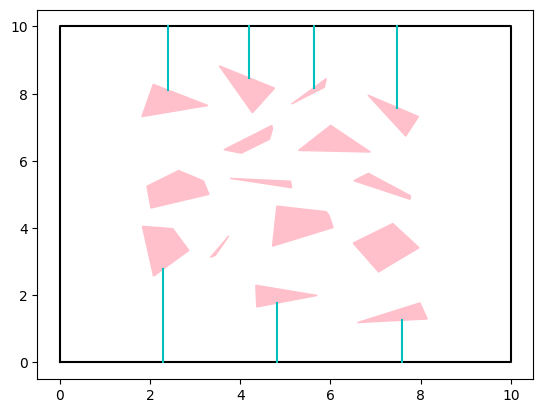

In [45]:
fig, ax = plt.subplots()

plt.plot([M.xmin, M.xmax, M.xmax, M.xmin, M.xmin], [M.ymin, M.ymin, M.ymax, M.ymax, M.ymin], color='black')

for obstacle in obstacle_list:
    x,y = obstacle.exterior.xy
    ax.fill(x, y, color = 'pink')
    
for BoundGate in hello:
    x, y = BoundGate.xy
    plt.plot(x, y, 'c-', linewidth = 1.5)

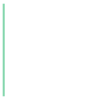

In [46]:
test_gate = hello[-1]
test_gate

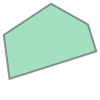

In [47]:
test_obst = obstacle_list[5]
test_obst

In [48]:
a = (test_gate - test_obst)

In [49]:
a.coords[0]

(4.806025089414635, 1.764355298710838)

In [50]:
M.CentroidList[5]

[(2.5689366757630636, 5.1517024489507435)]